In [22]:
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pathlib import Path

sys.path.append(os.path.abspath('..'))

from src.model import ECGCNN, ECGAutoencoder


In [24]:
import os

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [25]:
class ECGWindowDataset(Dataset):
    def __init__(self, windows_dir, record_ids):
        self.X = []
        self.y = []

        for rid in record_ids:
            self.X.append(np.load(windows_dir / f"{rid}_windows.npy"))
            self.y.append(np.load(windows_dir / f"{rid}_labels.npy"))

        self.X = np.concatenate(self.X, axis=0)
        self.y = np.concatenate(self.y, axis=0)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )


In [26]:
WINDOWS_DIR = Path("..") / "data" / "windows"

full_dataset = ECGWindowDataset(
    windows_dir=WINDOWS_DIR,
    record_ids=['100', '101', '103', '105']
)

print(f"Total windows: {len(full_dataset)}")


Total windows: 2884


In [27]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_data, val_data = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_cnn_loss = float("inf")

loss_history = []

epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        x = x.permute(0, 2, 1)  # (B, C, T)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # ✅ SAVE BEST CNN
    if avg_loss < best_cnn_loss:
        best_cnn_loss = avg_loss
        torch.save(
            model.state_dict(),
            os.path.join(MODEL_DIR, "best_cnn.pth")
        )
        print("✅ Best CNN model saved")



Epoch 1: Loss = 0.2330
✅ Best CNN model saved
Epoch 2: Loss = 0.1937
✅ Best CNN model saved
Epoch 3: Loss = 0.1987
Epoch 4: Loss = 0.1980
Epoch 5: Loss = 0.1952


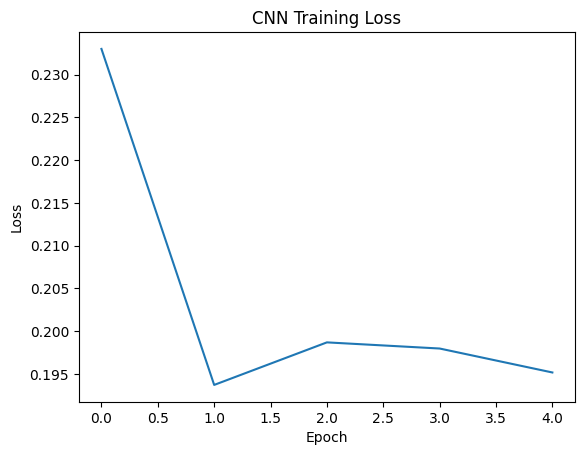

In [30]:
plt.plot(loss_history)
plt.title("CNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [32]:
best_ae_loss = float("inf")
ae = ECGAutoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(ae.parameters(), lr=0.001)

ae.train()
for x, _ in tqdm(train_loader, desc="AE Training"):
    x = x.to(device)
    x = x.permute(0, 2, 1)  # (B, C, T)

    optimizer_ae.zero_grad()
    recon = ae(x)
    loss = criterion_ae(recon, x)
    loss.backward()
    optimizer_ae.step()

    # Track best AE
    if loss.item() < best_ae_loss:
        best_ae_loss = loss.item()
        torch.save(
            ae.state_dict(),
            os.path.join(MODEL_DIR, "best_autoencoder.pth")
        )


AE Training: 100%|██████████| 73/73 [00:03<00:00, 22.01it/s]


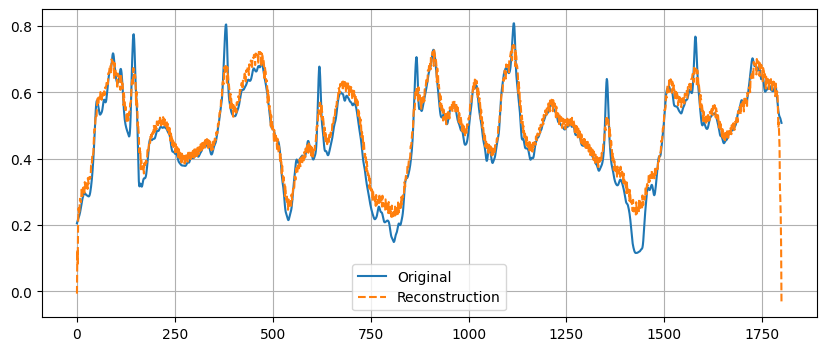

In [33]:
ae.eval()

sample, _ = val_data[0]
sample = sample.unsqueeze(0).to(device)     # (1, T, C)
sample = sample.permute(0, 2, 1)             # ✅ (1, C, T)

with torch.no_grad():
    recon = ae(sample)

plt.figure(figsize=(10, 4))
plt.plot(sample.cpu().numpy()[0, 0, :], label="Original")
plt.plot(recon.cpu().numpy()[0, 0, :], label="Reconstruction", linestyle="--")
plt.legend()
plt.grid()
plt.show()
